**Imports**

In [3]:
import torch
print(torch.__version__)
import torch.nn as nn
import pandas as pd
from collections import Counter
import numpy as np
import torchvision
import torch.nn.functional as F

## This module provides tools to transform images, such as resizing, cropping, flipping, converting to tensors, and normalizing
import torchvision.transforms as transforms

#This is a dataset class that loads images from a directory structure where each folder is treated as a separate class.
#It automatically assigns labels based on subfolder names.
import torchvision.datasets as datasets


#This utility creates an iterable over the dataset, allowing for loading data in batches, shuffling, and parallel data loading with multiple workers.
from torch.utils.data import DataLoader

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import torchvision.models as models
import copy
import random

# Import sklearn metrics for evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Import visualization tools
import matplotlib.pyplot as plt
import seaborn as sns



2.5.0+cu121


In [4]:
from torch.utils.data import DataLoader, random_split
# Set a fixed random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Additional settings for GPU reproducibility
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)            # If using multiple GPUs
torch.backends.cudnn.deterministic = True   # Ensures deterministic behavior for some GPU operations
torch.backends.cudnn.benchmark = False      # Disables auto-tuning for determinism

**Data Preprocessing and Load CIFAR-10 Dataset**

In [5]:
# Define Cutout transformation
class Cutout:
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)

        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.0

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img

# Define transformations for training, validation, and testing data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),          # Random cropping with padding
    transforms.RandomHorizontalFlip(),             # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Color Jitter
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # Normalize with CIFAR-10 stats
    Cutout(n_holes=1, length=8)                    # Cutout
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR-10 dataset
trainset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split the training set into training and validation sets
train_size = int(0.8 * len(trainset_full))
val_size = len(trainset_full) - train_size
trainset, valset = random_split(trainset_full, [train_size, val_size])



# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)


print(f"Number of training samples: {len(trainset)}")
print(f"Number of validation samples: {len(valset)}")
print(f"Number of test samples: {len(testset)}")

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


**Baseline CNN Architecture**

In [6]:


class BaselineCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(BaselineCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Input size calculated after pooling
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)  # Output layer for 10 classes (CIFAR-10)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Forward pass through convolutional layers + pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output for fully connected layers
        x = x.view(-1, 128 * 4 * 4)

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation in the output layer; CrossEntropyLoss handles softmax

        return x

# Initialize the model and print its structure
model = BaselineCNN()
print(model)


BaselineCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


**Loss Function, Optimizer, and Scheduler**

In [7]:


# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Cross-Entropy Loss with optional label smoothing
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: SGD with momentum and weight decay
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Scheduler: StepLR to decrease learning rate every 30 epochs by a factor of 0.1
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)


**Training and Validation Functions with Early Stopping**

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50, patience=5):
    # Track best validation loss
    best_val_loss = float('inf')
    patience_counter = 0

    # History for tracking losses and accuracy
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        avg_train_loss = running_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Check if validation loss improved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0  # Reset patience counter if there is improvement
            best_model_state = model.state_dict()  # Save the best model state
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                model.load_state_dict(best_model_state)  # Restore best model state
                break

        # Step the scheduler once per epoch
        if scheduler:
            scheduler.step()

    return model, history


**Training the Baseline Model and Evaluating Initial Performance**

In [9]:
# Initialize the Baseline CNN model
model = BaselineCNN()
model = model.to(device)

# Train the model and track metrics
num_epochs = 50
patience = 5

trained_model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs,
    patience=patience
)

# Display training history
print("\nTraining Complete. History of training:")
for epoch, (train_loss, val_loss, val_acc) in enumerate(zip(history['train_loss'], history['val_loss'], history['val_accuracy']), 1):
    print(f"Epoch {epoch} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")


Epoch [1/50], Train Loss: 2.3038, Val Loss: 2.3036, Val Accuracy: 9.65%
Epoch [2/50], Train Loss: 2.3038, Val Loss: 2.3036, Val Accuracy: 9.71%
Epoch [3/50], Train Loss: 2.3038, Val Loss: 2.3036, Val Accuracy: 9.84%
Epoch [4/50], Train Loss: 2.3037, Val Loss: 2.3036, Val Accuracy: 9.78%
Epoch [5/50], Train Loss: 2.3037, Val Loss: 2.3036, Val Accuracy: 9.56%
Epoch [6/50], Train Loss: 2.3037, Val Loss: 2.3036, Val Accuracy: 9.77%
Epoch [7/50], Train Loss: 2.3037, Val Loss: 2.3036, Val Accuracy: 9.89%
Epoch [8/50], Train Loss: 2.3038, Val Loss: 2.3035, Val Accuracy: 9.86%
Epoch [9/50], Train Loss: 2.3037, Val Loss: 2.3036, Val Accuracy: 9.83%
Epoch [10/50], Train Loss: 2.3038, Val Loss: 2.3036, Val Accuracy: 9.89%
Epoch [11/50], Train Loss: 2.3038, Val Loss: 2.3037, Val Accuracy: 9.81%
Epoch [12/50], Train Loss: 2.3037, Val Loss: 2.3037, Val Accuracy: 9.83%
Epoch [13/50], Train Loss: 2.3037, Val Loss: 2.3036, Val Accuracy: 9.92%
Early stopping triggered.

Training Complete. History of tra

**Plotting Training and Validation Curves**

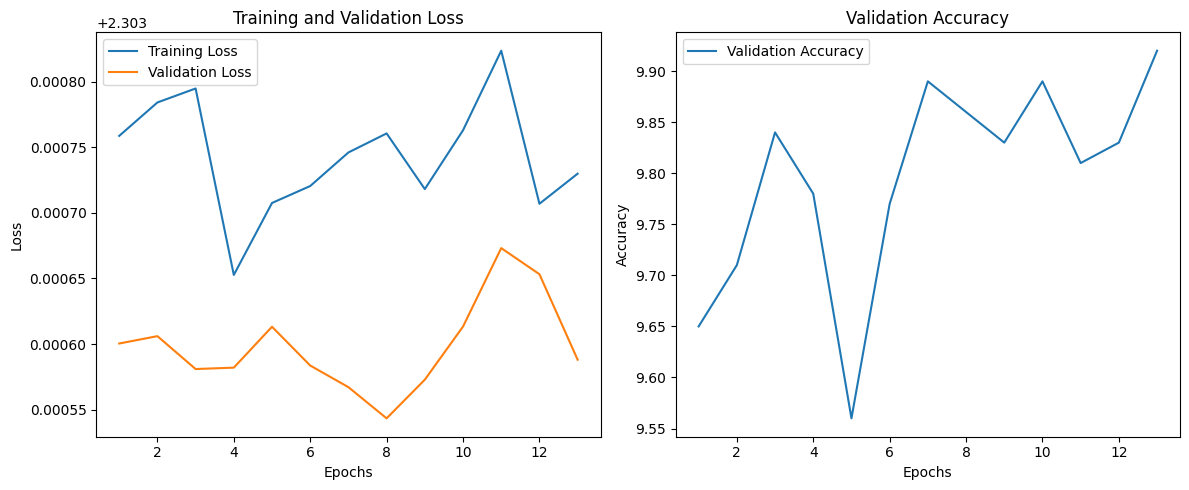

In [10]:


def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Training and Validation Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(history)


**Hyperparameter Optimization with Optuna**

In [12]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00


In [13]:
import optuna
from torch.utils.data import DataLoader

def objective(trial):
    # Suggest hyperparameters to optimize
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)  # Log scale for learning rate
    momentum = trial.suggest_float('momentum', 0.5, 0.99)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)

    # Initialize the model with suggested dropout rate
    model = BaselineCNN(dropout_rate=dropout_rate).to(device)

    # Set up optimizer and loss function
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Learning rate scheduler
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

    # Train and validate the model
    _, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10, patience=3)

    # Use validation loss of the last epoch as the objective to minimize
    val_loss = history['val_loss'][-1]

    return val_loss

# Run the Optuna study for hyperparameter tuning
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Adjust n_trials based on resources and needs

# Print and use the best hyperparameters found
best_params = study.best_params
print("Best hyperparameters:", best_params)


[I 2024-11-09 19:31:14,635] A new study created in memory with name: no-name-359eaa41-1105-44fc-8977-1e9109bf0494


Epoch [1/10], Train Loss: 2.3027, Val Loss: 2.3010, Val Accuracy: 12.81%
Epoch [2/10], Train Loss: 2.2998, Val Loss: 2.2975, Val Accuracy: 15.13%
Epoch [3/10], Train Loss: 2.2960, Val Loss: 2.2919, Val Accuracy: 19.63%
Epoch [4/10], Train Loss: 2.2871, Val Loss: 2.2761, Val Accuracy: 21.60%
Epoch [5/10], Train Loss: 2.2579, Val Loss: 2.2171, Val Accuracy: 21.93%
Epoch [6/10], Train Loss: 2.1833, Val Loss: 2.1331, Val Accuracy: 22.85%
Epoch [7/10], Train Loss: 2.1212, Val Loss: 2.0900, Val Accuracy: 25.22%
Epoch [8/10], Train Loss: 2.0871, Val Loss: 2.0594, Val Accuracy: 26.57%
Epoch [9/10], Train Loss: 2.0586, Val Loss: 2.0307, Val Accuracy: 28.86%


[I 2024-11-09 19:33:47,149] Trial 0 finished with value: 1.9970834768271144 and parameters: {'lr': 0.00030139689383287734, 'momentum': 0.9578904002852277, 'dropout_rate': 0.39442090186830014}. Best is trial 0 with value: 1.9970834768271144.


Epoch [10/10], Train Loss: 2.0315, Val Loss: 1.9971, Val Accuracy: 30.05%
Epoch [1/10], Train Loss: 2.3034, Val Loss: 2.3034, Val Accuracy: 9.86%
Epoch [2/10], Train Loss: 2.3030, Val Loss: 2.3028, Val Accuracy: 9.98%
Epoch [3/10], Train Loss: 2.3024, Val Loss: 2.3023, Val Accuracy: 9.99%
Epoch [4/10], Train Loss: 2.3020, Val Loss: 2.3018, Val Accuracy: 10.03%
Epoch [5/10], Train Loss: 2.3016, Val Loss: 2.3013, Val Accuracy: 10.03%
Epoch [6/10], Train Loss: 2.3011, Val Loss: 2.3008, Val Accuracy: 10.07%
Epoch [7/10], Train Loss: 2.3006, Val Loss: 2.3003, Val Accuracy: 10.07%
Epoch [8/10], Train Loss: 2.3002, Val Loss: 2.2997, Val Accuracy: 10.15%
Epoch [9/10], Train Loss: 2.2997, Val Loss: 2.2992, Val Accuracy: 10.28%


[I 2024-11-09 19:36:16,245] Trial 1 finished with value: 2.2986347886580454 and parameters: {'lr': 0.0004961926115975427, 'momentum': 0.672316831959904, 'dropout_rate': 0.40984268157502135}. Best is trial 0 with value: 1.9970834768271144.


Epoch [10/10], Train Loss: 2.2992, Val Loss: 2.2986, Val Accuracy: 10.69%
Epoch [1/10], Train Loss: 2.3032, Val Loss: 2.3029, Val Accuracy: 9.67%
Epoch [2/10], Train Loss: 2.3026, Val Loss: 2.3022, Val Accuracy: 9.98%
Epoch [3/10], Train Loss: 2.3019, Val Loss: 2.3016, Val Accuracy: 11.50%
Epoch [4/10], Train Loss: 2.3015, Val Loss: 2.3010, Val Accuracy: 13.03%
Epoch [5/10], Train Loss: 2.3008, Val Loss: 2.3004, Val Accuracy: 14.33%
Epoch [6/10], Train Loss: 2.3003, Val Loss: 2.2996, Val Accuracy: 14.67%
Epoch [7/10], Train Loss: 2.2996, Val Loss: 2.2988, Val Accuracy: 14.41%
Epoch [8/10], Train Loss: 2.2988, Val Loss: 2.2980, Val Accuracy: 15.12%
Epoch [9/10], Train Loss: 2.2981, Val Loss: 2.2970, Val Accuracy: 15.09%


[I 2024-11-09 19:38:46,584] Trial 2 finished with value: 2.295985810364349 and parameters: {'lr': 0.0005078196481447928, 'momentum': 0.6067914575589316, 'dropout_rate': 0.2950469883915454}. Best is trial 0 with value: 1.9970834768271144.


Epoch [10/10], Train Loss: 2.2970, Val Loss: 2.2960, Val Accuracy: 15.60%
Epoch [1/10], Train Loss: 2.3028, Val Loss: 2.3016, Val Accuracy: 10.10%
Epoch [2/10], Train Loss: 2.3015, Val Loss: 2.3002, Val Accuracy: 10.10%
Epoch [3/10], Train Loss: 2.3000, Val Loss: 2.2984, Val Accuracy: 10.30%
Epoch [4/10], Train Loss: 2.2979, Val Loss: 2.2960, Val Accuracy: 11.40%
Epoch [5/10], Train Loss: 2.2951, Val Loss: 2.2918, Val Accuracy: 13.04%
Epoch [6/10], Train Loss: 2.2903, Val Loss: 2.2846, Val Accuracy: 14.99%
Epoch [7/10], Train Loss: 2.2811, Val Loss: 2.2704, Val Accuracy: 17.81%
Epoch [8/10], Train Loss: 2.2625, Val Loss: 2.2410, Val Accuracy: 19.24%
Epoch [9/10], Train Loss: 2.2256, Val Loss: 2.1952, Val Accuracy: 21.74%


[I 2024-11-09 19:41:14,586] Trial 3 finished with value: 2.1632037011882925 and parameters: {'lr': 0.00034464929569961067, 'momentum': 0.9180036205465356, 'dropout_rate': 0.32070503182709703}. Best is trial 0 with value: 1.9970834768271144.


Epoch [10/10], Train Loss: 2.1897, Val Loss: 2.1632, Val Accuracy: 23.25%
Epoch [1/10], Train Loss: 2.2154, Val Loss: 2.0570, Val Accuracy: 26.32%
Epoch [2/10], Train Loss: 2.0054, Val Loss: 1.9087, Val Accuracy: 32.52%
Epoch [3/10], Train Loss: 1.8766, Val Loss: 1.8086, Val Accuracy: 39.94%
Epoch [4/10], Train Loss: 1.7929, Val Loss: 1.7309, Val Accuracy: 43.91%
Epoch [5/10], Train Loss: 1.7219, Val Loss: 1.6618, Val Accuracy: 47.17%
Epoch [6/10], Train Loss: 1.6706, Val Loss: 1.6682, Val Accuracy: 46.02%
Epoch [7/10], Train Loss: 1.6141, Val Loss: 1.5574, Val Accuracy: 51.84%
Epoch [8/10], Train Loss: 1.5614, Val Loss: 1.5129, Val Accuracy: 54.27%
Epoch [9/10], Train Loss: 1.5178, Val Loss: 1.4672, Val Accuracy: 56.46%


[I 2024-11-09 19:43:44,154] Trial 4 finished with value: 1.424857652640041 and parameters: {'lr': 0.025439895891979977, 'momentum': 0.6199707799457247, 'dropout_rate': 0.4896461050465301}. Best is trial 4 with value: 1.424857652640041.


Epoch [10/10], Train Loss: 1.4764, Val Loss: 1.4249, Val Accuracy: 57.96%
Epoch [1/10], Train Loss: 2.3022, Val Loss: 2.3006, Val Accuracy: 10.10%
Epoch [2/10], Train Loss: 2.3001, Val Loss: 2.2981, Val Accuracy: 10.10%
Epoch [3/10], Train Loss: 2.2973, Val Loss: 2.2948, Val Accuracy: 10.99%
Epoch [4/10], Train Loss: 2.2935, Val Loss: 2.2896, Val Accuracy: 13.12%
Epoch [5/10], Train Loss: 2.2878, Val Loss: 2.2813, Val Accuracy: 15.98%
Epoch [6/10], Train Loss: 2.2778, Val Loss: 2.2693, Val Accuracy: 16.57%
Epoch [7/10], Train Loss: 2.2644, Val Loss: 2.2516, Val Accuracy: 17.05%
Epoch [8/10], Train Loss: 2.2451, Val Loss: 2.2308, Val Accuracy: 18.29%
Epoch [9/10], Train Loss: 2.2228, Val Loss: 2.2021, Val Accuracy: 20.14%


[I 2024-11-09 19:46:13,126] Trial 5 finished with value: 2.168937372255929 and parameters: {'lr': 0.0015993516815877894, 'momentum': 0.5074400348658173, 'dropout_rate': 0.42408428546851645}. Best is trial 4 with value: 1.424857652640041.


Epoch [10/10], Train Loss: 2.1962, Val Loss: 2.1689, Val Accuracy: 21.92%
Epoch [1/10], Train Loss: 2.1557, Val Loss: 1.9907, Val Accuracy: 29.54%
Epoch [2/10], Train Loss: 1.8971, Val Loss: 1.8449, Val Accuracy: 37.97%
Epoch [3/10], Train Loss: 1.7602, Val Loss: 1.6838, Val Accuracy: 44.78%
Epoch [4/10], Train Loss: 1.6694, Val Loss: 1.6227, Val Accuracy: 47.58%
Epoch [5/10], Train Loss: 1.5987, Val Loss: 1.5004, Val Accuracy: 53.72%
Epoch [6/10], Train Loss: 1.5122, Val Loss: 1.4943, Val Accuracy: 55.26%
Epoch [7/10], Train Loss: 1.4585, Val Loss: 1.4533, Val Accuracy: 57.01%
Epoch [8/10], Train Loss: 1.4048, Val Loss: 1.4063, Val Accuracy: 59.67%
Epoch [9/10], Train Loss: 1.3655, Val Loss: 1.3730, Val Accuracy: 61.03%


[I 2024-11-09 19:48:40,594] Trial 6 finished with value: 1.2828398143188864 and parameters: {'lr': 0.050913087911942996, 'momentum': 0.5148102978930678, 'dropout_rate': 0.3270882136666331}. Best is trial 6 with value: 1.2828398143188864.


Epoch [10/10], Train Loss: 1.3267, Val Loss: 1.2828, Val Accuracy: 65.31%
Epoch [1/10], Train Loss: 2.3044, Val Loss: 2.3034, Val Accuracy: 9.63%
Epoch [2/10], Train Loss: 2.3025, Val Loss: 2.3016, Val Accuracy: 9.63%
Epoch [3/10], Train Loss: 2.3012, Val Loss: 2.3000, Val Accuracy: 11.04%
Epoch [4/10], Train Loss: 2.2998, Val Loss: 2.2985, Val Accuracy: 14.39%
Epoch [5/10], Train Loss: 2.2978, Val Loss: 2.2962, Val Accuracy: 15.63%
Epoch [6/10], Train Loss: 2.2956, Val Loss: 2.2931, Val Accuracy: 17.39%
Epoch [7/10], Train Loss: 2.2920, Val Loss: 2.2886, Val Accuracy: 18.94%
Epoch [8/10], Train Loss: 2.2866, Val Loss: 2.2804, Val Accuracy: 19.69%
Epoch [9/10], Train Loss: 2.2769, Val Loss: 2.2672, Val Accuracy: 19.45%


[I 2024-11-09 19:51:08,150] Trial 7 finished with value: 2.2456510640397855 and parameters: {'lr': 0.0012944446799648508, 'momentum': 0.608933920111618, 'dropout_rate': 0.4445020065111811}. Best is trial 6 with value: 1.2828398143188864.


Epoch [10/10], Train Loss: 2.2609, Val Loss: 2.2457, Val Accuracy: 20.76%
Epoch [1/10], Train Loss: 2.0407, Val Loss: 1.8035, Val Accuracy: 38.03%
Epoch [2/10], Train Loss: 1.7524, Val Loss: 1.6523, Val Accuracy: 46.92%
Epoch [3/10], Train Loss: 1.5953, Val Loss: 1.5187, Val Accuracy: 54.64%
Epoch [4/10], Train Loss: 1.4851, Val Loss: 1.4244, Val Accuracy: 58.48%
Epoch [5/10], Train Loss: 1.4038, Val Loss: 1.3336, Val Accuracy: 63.13%
Epoch [6/10], Train Loss: 1.3365, Val Loss: 1.3120, Val Accuracy: 63.97%
Epoch [7/10], Train Loss: 1.3009, Val Loss: 1.3135, Val Accuracy: 63.73%
Epoch [8/10], Train Loss: 1.2585, Val Loss: 1.2290, Val Accuracy: 67.31%
Epoch [9/10], Train Loss: 1.2416, Val Loss: 1.2176, Val Accuracy: 67.90%


[I 2024-11-09 19:53:37,267] Trial 8 finished with value: 1.1870458299600626 and parameters: {'lr': 0.043534753081609506, 'momentum': 0.8426002324827179, 'dropout_rate': 0.3827548197400593}. Best is trial 8 with value: 1.1870458299600626.


Epoch [10/10], Train Loss: 1.2104, Val Loss: 1.1870, Val Accuracy: 69.12%
Epoch [1/10], Train Loss: 2.0541, Val Loss: 1.8390, Val Accuracy: 36.38%
Epoch [2/10], Train Loss: 1.7815, Val Loss: 1.6241, Val Accuracy: 47.64%
Epoch [3/10], Train Loss: 1.6215, Val Loss: 1.5103, Val Accuracy: 54.29%
Epoch [4/10], Train Loss: 1.4978, Val Loss: 1.4184, Val Accuracy: 58.62%
Epoch [5/10], Train Loss: 1.4267, Val Loss: 1.3682, Val Accuracy: 61.13%
Epoch [6/10], Train Loss: 1.3683, Val Loss: 1.3960, Val Accuracy: 60.02%
Epoch [7/10], Train Loss: 1.3187, Val Loss: 1.2940, Val Accuracy: 64.42%
Epoch [8/10], Train Loss: 1.2840, Val Loss: 1.2664, Val Accuracy: 66.42%
Epoch [9/10], Train Loss: 1.2611, Val Loss: 1.2090, Val Accuracy: 68.90%


[I 2024-11-09 19:56:06,476] Trial 9 finished with value: 1.16698174235187 and parameters: {'lr': 0.027264305771265665, 'momentum': 0.907606332629421, 'dropout_rate': 0.4402153564262413}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.2374, Val Loss: 1.1670, Val Accuracy: 70.08%
Epoch [1/10], Train Loss: 2.2501, Val Loss: 2.1073, Val Accuracy: 24.84%
Epoch [2/10], Train Loss: 2.0361, Val Loss: 1.9431, Val Accuracy: 32.56%
Epoch [3/10], Train Loss: 1.9031, Val Loss: 1.8482, Val Accuracy: 36.74%
Epoch [4/10], Train Loss: 1.8119, Val Loss: 1.7488, Val Accuracy: 42.11%
Epoch [5/10], Train Loss: 1.7518, Val Loss: 1.7164, Val Accuracy: 43.50%
Epoch [6/10], Train Loss: 1.7032, Val Loss: 1.6557, Val Accuracy: 46.59%
Epoch [7/10], Train Loss: 1.6551, Val Loss: 1.6205, Val Accuracy: 48.49%
Epoch [8/10], Train Loss: 1.6064, Val Loss: 1.5647, Val Accuracy: 51.03%
Epoch [9/10], Train Loss: 1.5649, Val Loss: 1.5248, Val Accuracy: 52.91%


[I 2024-11-09 19:58:35,210] Trial 10 finished with value: 1.4845054738129242 and parameters: {'lr': 0.008474836240793123, 'momentum': 0.7981820146588795, 'dropout_rate': 0.21625527638718364}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.5219, Val Loss: 1.4845, Val Accuracy: 55.35%
Epoch [1/10], Train Loss: 2.0019, Val Loss: 1.8375, Val Accuracy: 36.10%
Epoch [2/10], Train Loss: 1.7260, Val Loss: 1.5523, Val Accuracy: 51.00%
Epoch [3/10], Train Loss: 1.5688, Val Loss: 1.4619, Val Accuracy: 57.12%
Epoch [4/10], Train Loss: 1.4775, Val Loss: 1.4142, Val Accuracy: 58.82%
Epoch [5/10], Train Loss: 1.4096, Val Loss: 1.3212, Val Accuracy: 63.49%
Epoch [6/10], Train Loss: 1.3668, Val Loss: 1.3190, Val Accuracy: 62.76%
Epoch [7/10], Train Loss: 1.3353, Val Loss: 1.2868, Val Accuracy: 64.54%
Epoch [8/10], Train Loss: 1.3134, Val Loss: 1.2728, Val Accuracy: 65.26%
Epoch [9/10], Train Loss: 1.2823, Val Loss: 1.2447, Val Accuracy: 66.78%


[I 2024-11-09 20:01:02,662] Trial 11 finished with value: 1.2478792456131946 and parameters: {'lr': 0.08963803389753554, 'momentum': 0.8425776725139287, 'dropout_rate': 0.4938142334516479}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.2675, Val Loss: 1.2479, Val Accuracy: 66.93%
Epoch [1/10], Train Loss: 2.1759, Val Loss: 1.9803, Val Accuracy: 29.91%
Epoch [2/10], Train Loss: 1.8797, Val Loss: 1.7850, Val Accuracy: 40.12%
Epoch [3/10], Train Loss: 1.7532, Val Loss: 1.6613, Val Accuracy: 45.57%
Epoch [4/10], Train Loss: 1.6532, Val Loss: 1.5734, Val Accuracy: 50.53%
Epoch [5/10], Train Loss: 1.5535, Val Loss: 1.4910, Val Accuracy: 55.05%
Epoch [6/10], Train Loss: 1.4851, Val Loss: 1.4063, Val Accuracy: 58.90%
Epoch [7/10], Train Loss: 1.4317, Val Loss: 1.3632, Val Accuracy: 61.30%
Epoch [8/10], Train Loss: 1.3850, Val Loss: 1.3312, Val Accuracy: 62.86%
Epoch [9/10], Train Loss: 1.3388, Val Loss: 1.3367, Val Accuracy: 62.88%


[I 2024-11-09 20:03:30,496] Trial 12 finished with value: 1.2848350066172927 and parameters: {'lr': 0.013692953622562641, 'momentum': 0.8756270695707854, 'dropout_rate': 0.3688096613120253}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.3093, Val Loss: 1.2848, Val Accuracy: 64.90%
Epoch [1/10], Train Loss: 2.1278, Val Loss: 1.9136, Val Accuracy: 33.28%
Epoch [2/10], Train Loss: 1.8571, Val Loss: 1.7358, Val Accuracy: 42.11%
Epoch [3/10], Train Loss: 1.7518, Val Loss: 1.6169, Val Accuracy: 47.90%
Epoch [4/10], Train Loss: 1.6552, Val Loss: 1.5582, Val Accuracy: 51.03%
Epoch [5/10], Train Loss: 1.5850, Val Loss: 1.5094, Val Accuracy: 53.97%
Epoch [6/10], Train Loss: 1.5365, Val Loss: 1.4729, Val Accuracy: 56.48%
Epoch [7/10], Train Loss: 1.5113, Val Loss: 1.4421, Val Accuracy: 57.54%
Epoch [8/10], Train Loss: 1.4674, Val Loss: 1.4382, Val Accuracy: 57.94%
Epoch [9/10], Train Loss: 1.4483, Val Loss: 1.4062, Val Accuracy: 60.06%


[I 2024-11-09 20:05:58,345] Trial 13 finished with value: 1.3803569168984136 and parameters: {'lr': 0.00788339514999592, 'momentum': 0.9899380215508746, 'dropout_rate': 0.45820735389568673}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.4348, Val Loss: 1.3804, Val Accuracy: 60.86%
Epoch [1/10], Train Loss: 2.0766, Val Loss: 1.8796, Val Accuracy: 34.16%
Epoch [2/10], Train Loss: 1.7958, Val Loss: 1.7021, Val Accuracy: 42.92%
Epoch [3/10], Train Loss: 1.6630, Val Loss: 1.6223, Val Accuracy: 49.43%
Epoch [4/10], Train Loss: 1.5502, Val Loss: 1.4945, Val Accuracy: 55.24%
Epoch [5/10], Train Loss: 1.4622, Val Loss: 1.3869, Val Accuracy: 60.64%
Epoch [6/10], Train Loss: 1.3949, Val Loss: 1.3399, Val Accuracy: 62.82%
Epoch [7/10], Train Loss: 1.3390, Val Loss: 1.2841, Val Accuracy: 64.77%
Epoch [8/10], Train Loss: 1.3019, Val Loss: 1.2652, Val Accuracy: 66.40%
Epoch [9/10], Train Loss: 1.2719, Val Loss: 1.2334, Val Accuracy: 67.61%


[I 2024-11-09 20:08:26,805] Trial 14 finished with value: 1.2547031007235563 and parameters: {'lr': 0.04030394224843066, 'momentum': 0.7875242492729505, 'dropout_rate': 0.3704272061799722}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.2379, Val Loss: 1.2547, Val Accuracy: 66.69%
Epoch [1/10], Train Loss: 2.3021, Val Loss: 2.3003, Val Accuracy: 10.57%
Epoch [2/10], Train Loss: 2.2990, Val Loss: 2.2960, Val Accuracy: 16.60%
Epoch [3/10], Train Loss: 2.2914, Val Loss: 2.2808, Val Accuracy: 17.08%
Epoch [4/10], Train Loss: 2.2497, Val Loss: 2.1798, Val Accuracy: 22.96%
Epoch [5/10], Train Loss: 2.1173, Val Loss: 2.0641, Val Accuracy: 25.93%
Epoch [6/10], Train Loss: 2.0511, Val Loss: 2.0227, Val Accuracy: 28.09%
Epoch [7/10], Train Loss: 2.0106, Val Loss: 1.9780, Val Accuracy: 30.67%
Epoch [8/10], Train Loss: 1.9614, Val Loss: 1.9209, Val Accuracy: 33.54%
Epoch [9/10], Train Loss: 1.9160, Val Loss: 1.8735, Val Accuracy: 34.90%


[I 2024-11-09 20:10:53,619] Trial 15 finished with value: 1.8358878666841532 and parameters: {'lr': 0.002973144766696083, 'momentum': 0.7444340914210056, 'dropout_rate': 0.26496151818263486}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.8781, Val Loss: 1.8359, Val Accuracy: 36.96%
Epoch [1/10], Train Loss: 2.0174, Val Loss: 1.8125, Val Accuracy: 38.25%
Epoch [2/10], Train Loss: 1.7518, Val Loss: 1.6035, Val Accuracy: 48.92%
Epoch [3/10], Train Loss: 1.6374, Val Loss: 1.5929, Val Accuracy: 49.88%
Epoch [4/10], Train Loss: 1.5511, Val Loss: 1.4513, Val Accuracy: 57.01%
Epoch [5/10], Train Loss: 1.4921, Val Loss: 1.4630, Val Accuracy: 58.03%
Epoch [6/10], Train Loss: 1.4710, Val Loss: 1.5262, Val Accuracy: 55.74%
Epoch [7/10], Train Loss: 1.4298, Val Loss: 1.3838, Val Accuracy: 61.35%
Epoch [8/10], Train Loss: 1.4134, Val Loss: 1.3696, Val Accuracy: 62.30%
Epoch [9/10], Train Loss: 1.4015, Val Loss: 1.3418, Val Accuracy: 63.33%


[I 2024-11-09 20:13:19,194] Trial 16 finished with value: 1.3368480431882641 and parameters: {'lr': 0.09944802067394372, 'momentum': 0.8887597423850607, 'dropout_rate': 0.4541138171617652}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.3759, Val Loss: 1.3368, Val Accuracy: 63.47%
Epoch [1/10], Train Loss: 2.2072, Val Loss: 2.0567, Val Accuracy: 27.30%
Epoch [2/10], Train Loss: 1.9765, Val Loss: 1.8995, Val Accuracy: 33.93%
Epoch [3/10], Train Loss: 1.8467, Val Loss: 1.8547, Val Accuracy: 38.66%
Epoch [4/10], Train Loss: 1.7659, Val Loss: 1.6868, Val Accuracy: 45.31%
Epoch [5/10], Train Loss: 1.7122, Val Loss: 1.6613, Val Accuracy: 46.02%
Epoch [6/10], Train Loss: 1.6483, Val Loss: 1.5868, Val Accuracy: 50.76%
Epoch [7/10], Train Loss: 1.5999, Val Loss: 1.5357, Val Accuracy: 52.31%
Epoch [8/10], Train Loss: 1.5427, Val Loss: 1.5030, Val Accuracy: 54.61%
Epoch [9/10], Train Loss: 1.5044, Val Loss: 1.4963, Val Accuracy: 54.31%


[I 2024-11-09 20:15:49,090] Trial 17 finished with value: 1.4205865965613835 and parameters: {'lr': 0.01782194684199024, 'momentum': 0.720636271522457, 'dropout_rate': 0.38614208802784683}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.4623, Val Loss: 1.4206, Val Accuracy: 58.77%
Epoch [1/10], Train Loss: 2.2757, Val Loss: 2.2170, Val Accuracy: 19.54%
Epoch [2/10], Train Loss: 2.1203, Val Loss: 2.0385, Val Accuracy: 27.74%
Epoch [3/10], Train Loss: 1.9935, Val Loss: 1.9427, Val Accuracy: 32.81%
Epoch [4/10], Train Loss: 1.9036, Val Loss: 1.8372, Val Accuracy: 37.31%
Epoch [5/10], Train Loss: 1.8319, Val Loss: 1.7674, Val Accuracy: 40.91%
Epoch [6/10], Train Loss: 1.7851, Val Loss: 1.7264, Val Accuracy: 43.35%
Epoch [7/10], Train Loss: 1.7419, Val Loss: 1.7201, Val Accuracy: 43.53%
Epoch [8/10], Train Loss: 1.7043, Val Loss: 1.6504, Val Accuracy: 46.75%
Epoch [9/10], Train Loss: 1.6700, Val Loss: 1.6119, Val Accuracy: 48.98%


[I 2024-11-09 20:18:17,402] Trial 18 finished with value: 1.6047280046004284 and parameters: {'lr': 0.0058283431887368575, 'momentum': 0.8173481800706591, 'dropout_rate': 0.33894128919254163}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.6327, Val Loss: 1.6047, Val Accuracy: 49.21%
Epoch [1/10], Train Loss: 2.3035, Val Loss: 2.3029, Val Accuracy: 10.10%
Epoch [2/10], Train Loss: 2.3028, Val Loss: 2.3021, Val Accuracy: 10.10%
Epoch [3/10], Train Loss: 2.3021, Val Loss: 2.3013, Val Accuracy: 10.10%
Epoch [4/10], Train Loss: 2.3014, Val Loss: 2.3005, Val Accuracy: 10.10%
Epoch [5/10], Train Loss: 2.3004, Val Loss: 2.2996, Val Accuracy: 10.10%
Epoch [6/10], Train Loss: 2.2997, Val Loss: 2.2986, Val Accuracy: 10.10%
Epoch [7/10], Train Loss: 2.2987, Val Loss: 2.2973, Val Accuracy: 10.11%
Epoch [8/10], Train Loss: 2.2977, Val Loss: 2.2962, Val Accuracy: 10.43%
Epoch [9/10], Train Loss: 2.2962, Val Loss: 2.2946, Val Accuracy: 11.96%


[I 2024-11-09 20:20:47,214] Trial 19 finished with value: 2.292340981809399 and parameters: {'lr': 0.00012970032142678483, 'momentum': 0.9285684025795897, 'dropout_rate': 0.4278851237647052}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 2.2945, Val Loss: 2.2923, Val Accuracy: 13.32%
Epoch [1/10], Train Loss: 2.0475, Val Loss: 1.8477, Val Accuracy: 36.14%
Epoch [2/10], Train Loss: 1.7506, Val Loss: 1.6397, Val Accuracy: 47.18%
Epoch [3/10], Train Loss: 1.5932, Val Loss: 1.5321, Val Accuracy: 52.09%
Epoch [4/10], Train Loss: 1.4754, Val Loss: 1.3968, Val Accuracy: 59.69%
Epoch [5/10], Train Loss: 1.3894, Val Loss: 1.3183, Val Accuracy: 62.82%
Epoch [6/10], Train Loss: 1.3347, Val Loss: 1.3357, Val Accuracy: 62.85%
Epoch [7/10], Train Loss: 1.2828, Val Loss: 1.2483, Val Accuracy: 66.92%
Epoch [8/10], Train Loss: 1.2487, Val Loss: 1.2263, Val Accuracy: 68.10%
Epoch [9/10], Train Loss: 1.2180, Val Loss: 1.1960, Val Accuracy: 69.22%


[I 2024-11-09 20:23:14,764] Trial 20 finished with value: 1.1888792243184922 and parameters: {'lr': 0.03649052285238152, 'momentum': 0.8570370468677909, 'dropout_rate': 0.29400971277551324}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.1958, Val Loss: 1.1889, Val Accuracy: 69.67%
Epoch [1/10], Train Loss: 2.0236, Val Loss: 1.7843, Val Accuracy: 39.76%
Epoch [2/10], Train Loss: 1.7482, Val Loss: 1.6592, Val Accuracy: 47.10%
Epoch [3/10], Train Loss: 1.5997, Val Loss: 1.4660, Val Accuracy: 56.15%
Epoch [4/10], Train Loss: 1.4844, Val Loss: 1.4393, Val Accuracy: 57.56%
Epoch [5/10], Train Loss: 1.3928, Val Loss: 1.3127, Val Accuracy: 63.94%
Epoch [6/10], Train Loss: 1.3406, Val Loss: 1.2782, Val Accuracy: 65.05%
Epoch [7/10], Train Loss: 1.2930, Val Loss: 1.2834, Val Accuracy: 64.56%
Epoch [8/10], Train Loss: 1.2525, Val Loss: 1.1986, Val Accuracy: 68.68%
Epoch [9/10], Train Loss: 1.2246, Val Loss: 1.1873, Val Accuracy: 68.84%


[I 2024-11-09 20:25:41,763] Trial 21 finished with value: 1.1693682142450839 and parameters: {'lr': 0.03697407585046834, 'momentum': 0.8573144516418297, 'dropout_rate': 0.2647877226968681}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.2010, Val Loss: 1.1694, Val Accuracy: 70.17%
Epoch [1/10], Train Loss: 1.9835, Val Loss: 1.8707, Val Accuracy: 36.22%
Epoch [2/10], Train Loss: 1.6916, Val Loss: 1.5841, Val Accuracy: 49.76%
Epoch [3/10], Train Loss: 1.5251, Val Loss: 1.4337, Val Accuracy: 57.90%
Epoch [4/10], Train Loss: 1.4414, Val Loss: 1.4518, Val Accuracy: 57.11%
Epoch [5/10], Train Loss: 1.3840, Val Loss: 1.3230, Val Accuracy: 63.30%
Epoch [6/10], Train Loss: 1.3454, Val Loss: 1.3485, Val Accuracy: 62.39%
Epoch [7/10], Train Loss: 1.3085, Val Loss: 1.2976, Val Accuracy: 64.83%
Epoch [8/10], Train Loss: 1.2904, Val Loss: 1.2388, Val Accuracy: 67.25%
Epoch [9/10], Train Loss: 1.2729, Val Loss: 1.3093, Val Accuracy: 63.84%


[I 2024-11-09 20:28:08,435] Trial 22 finished with value: 1.252516802353195 and parameters: {'lr': 0.06178246605239777, 'momentum': 0.909556090151987, 'dropout_rate': 0.24405919272723367}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.2499, Val Loss: 1.2525, Val Accuracy: 66.72%
Epoch [1/10], Train Loss: 2.1597, Val Loss: 2.0058, Val Accuracy: 29.72%
Epoch [2/10], Train Loss: 1.9004, Val Loss: 1.7834, Val Accuracy: 40.06%
Epoch [3/10], Train Loss: 1.7583, Val Loss: 1.6848, Val Accuracy: 44.60%
Epoch [4/10], Train Loss: 1.6651, Val Loss: 1.6245, Val Accuracy: 47.48%
Epoch [5/10], Train Loss: 1.5907, Val Loss: 1.5259, Val Accuracy: 52.98%
Epoch [6/10], Train Loss: 1.5198, Val Loss: 1.4498, Val Accuracy: 56.72%
Epoch [7/10], Train Loss: 1.4524, Val Loss: 1.4017, Val Accuracy: 58.98%
Epoch [8/10], Train Loss: 1.4077, Val Loss: 1.3752, Val Accuracy: 60.48%
Epoch [9/10], Train Loss: 1.3598, Val Loss: 1.3190, Val Accuracy: 64.12%


[I 2024-11-09 20:30:34,144] Trial 23 finished with value: 1.3278553712217114 and parameters: {'lr': 0.019658966638786683, 'momentum': 0.7789143881900824, 'dropout_rate': 0.20875625385911323}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.3177, Val Loss: 1.3279, Val Accuracy: 62.81%
Epoch [1/10], Train Loss: 2.2252, Val Loss: 2.0405, Val Accuracy: 27.94%
Epoch [2/10], Train Loss: 1.9508, Val Loss: 1.8515, Val Accuracy: 37.70%
Epoch [3/10], Train Loss: 1.8065, Val Loss: 1.7286, Val Accuracy: 42.53%
Epoch [4/10], Train Loss: 1.7276, Val Loss: 1.6580, Val Accuracy: 46.58%
Epoch [5/10], Train Loss: 1.6561, Val Loss: 1.5844, Val Accuracy: 50.15%
Epoch [6/10], Train Loss: 1.5964, Val Loss: 1.5341, Val Accuracy: 53.07%
Epoch [7/10], Train Loss: 1.5307, Val Loss: 1.4679, Val Accuracy: 56.58%
Epoch [8/10], Train Loss: 1.4753, Val Loss: 1.4019, Val Accuracy: 59.02%
Epoch [9/10], Train Loss: 1.4234, Val Loss: 1.3415, Val Accuracy: 62.32%


[I 2024-11-09 20:32:58,774] Trial 24 finished with value: 1.328961643991591 and parameters: {'lr': 0.01244517061435096, 'momentum': 0.8375799776994068, 'dropout_rate': 0.366058057967232}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.3784, Val Loss: 1.3290, Val Accuracy: 62.92%
Epoch [1/10], Train Loss: 2.0294, Val Loss: 1.8153, Val Accuracy: 38.51%
Epoch [2/10], Train Loss: 1.7565, Val Loss: 1.6048, Val Accuracy: 48.12%
Epoch [3/10], Train Loss: 1.5736, Val Loss: 1.4924, Val Accuracy: 54.98%
Epoch [4/10], Train Loss: 1.4703, Val Loss: 1.4316, Val Accuracy: 58.58%
Epoch [5/10], Train Loss: 1.4004, Val Loss: 1.3210, Val Accuracy: 63.11%
Epoch [6/10], Train Loss: 1.3547, Val Loss: 1.3340, Val Accuracy: 62.94%
Epoch [7/10], Train Loss: 1.3282, Val Loss: 1.2664, Val Accuracy: 65.64%
Epoch [8/10], Train Loss: 1.2946, Val Loss: 1.2366, Val Accuracy: 67.36%
Epoch [9/10], Train Loss: 1.2646, Val Loss: 1.2478, Val Accuracy: 66.61%


[I 2024-11-09 20:35:24,068] Trial 25 finished with value: 1.2457547972473917 and parameters: {'lr': 0.02990278764925513, 'momentum': 0.9524062893357704, 'dropout_rate': 0.3052438346616828}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.2661, Val Loss: 1.2458, Val Accuracy: 66.59%
Epoch [1/10], Train Loss: 2.2930, Val Loss: 2.2511, Val Accuracy: 20.36%
Epoch [2/10], Train Loss: 2.1167, Val Loss: 2.0309, Val Accuracy: 28.11%
Epoch [3/10], Train Loss: 1.9821, Val Loss: 1.9110, Val Accuracy: 34.24%
Epoch [4/10], Train Loss: 1.8731, Val Loss: 1.8108, Val Accuracy: 38.31%
Epoch [5/10], Train Loss: 1.8053, Val Loss: 1.7551, Val Accuracy: 41.74%
Epoch [6/10], Train Loss: 1.7574, Val Loss: 1.7247, Val Accuracy: 43.30%
Epoch [7/10], Train Loss: 1.7138, Val Loss: 1.6616, Val Accuracy: 45.80%
Epoch [8/10], Train Loss: 1.6759, Val Loss: 1.6416, Val Accuracy: 47.88%
Epoch [9/10], Train Loss: 1.6384, Val Loss: 1.6000, Val Accuracy: 48.71%


[I 2024-11-09 20:37:49,458] Trial 26 finished with value: 1.5500203069252303 and parameters: {'lr': 0.004144817925050489, 'momentum': 0.8788873046697854, 'dropout_rate': 0.2684465377500479}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.6022, Val Loss: 1.5500, Val Accuracy: 52.12%
Epoch [1/10], Train Loss: 2.1197, Val Loss: 2.0104, Val Accuracy: 30.11%
Epoch [2/10], Train Loss: 1.8354, Val Loss: 1.7351, Val Accuracy: 42.19%
Epoch [3/10], Train Loss: 1.6943, Val Loss: 1.5635, Val Accuracy: 51.00%
Epoch [4/10], Train Loss: 1.5824, Val Loss: 1.4965, Val Accuracy: 55.94%
Epoch [5/10], Train Loss: 1.4922, Val Loss: 1.3851, Val Accuracy: 60.20%
Epoch [6/10], Train Loss: 1.4158, Val Loss: 1.3774, Val Accuracy: 60.16%
Epoch [7/10], Train Loss: 1.3698, Val Loss: 1.3239, Val Accuracy: 62.93%
Epoch [8/10], Train Loss: 1.3237, Val Loss: 1.2989, Val Accuracy: 64.24%
Epoch [9/10], Train Loss: 1.2858, Val Loss: 1.2175, Val Accuracy: 68.21%


[I 2024-11-09 20:40:14,860] Trial 27 finished with value: 1.200988540166541 and parameters: {'lr': 0.04892400770099514, 'momentum': 0.7561260246886299, 'dropout_rate': 0.47024653554333684}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.2605, Val Loss: 1.2010, Val Accuracy: 69.44%
Epoch [1/10], Train Loss: 2.0058, Val Loss: 1.8562, Val Accuracy: 36.38%
Epoch [2/10], Train Loss: 1.7220, Val Loss: 1.6707, Val Accuracy: 46.12%
Epoch [3/10], Train Loss: 1.5674, Val Loss: 1.5162, Val Accuracy: 54.19%
Epoch [4/10], Train Loss: 1.4594, Val Loss: 1.3979, Val Accuracy: 59.51%
Epoch [5/10], Train Loss: 1.3849, Val Loss: 1.3533, Val Accuracy: 61.56%
Epoch [6/10], Train Loss: 1.3264, Val Loss: 1.3077, Val Accuracy: 64.03%
Epoch [7/10], Train Loss: 1.2837, Val Loss: 1.2591, Val Accuracy: 65.74%
Epoch [8/10], Train Loss: 1.2591, Val Loss: 1.2489, Val Accuracy: 67.11%
Epoch [9/10], Train Loss: 1.2236, Val Loss: 1.2015, Val Accuracy: 68.92%


[I 2024-11-09 20:42:40,943] Trial 28 finished with value: 1.181805882272841 and parameters: {'lr': 0.06826831915547345, 'momentum': 0.8156121153079714, 'dropout_rate': 0.35324647481169114}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.2081, Val Loss: 1.1818, Val Accuracy: 69.12%
Epoch [1/10], Train Loss: 2.0667, Val Loss: 1.9133, Val Accuracy: 34.05%
Epoch [2/10], Train Loss: 1.8750, Val Loss: 1.8335, Val Accuracy: 37.79%
Epoch [3/10], Train Loss: 1.8064, Val Loss: 1.7078, Val Accuracy: 44.41%
Epoch [4/10], Train Loss: 1.7877, Val Loss: 1.7342, Val Accuracy: 43.38%
Epoch [5/10], Train Loss: 1.7957, Val Loss: 1.7070, Val Accuracy: 44.56%
Epoch [6/10], Train Loss: 1.7540, Val Loss: 1.7244, Val Accuracy: 44.68%
Epoch [7/10], Train Loss: 1.7545, Val Loss: 1.7138, Val Accuracy: 44.15%
Epoch [8/10], Train Loss: 1.7258, Val Loss: 1.6951, Val Accuracy: 45.69%
Epoch [9/10], Train Loss: 1.7250, Val Loss: 1.6691, Val Accuracy: 48.03%


[I 2024-11-09 20:45:07,486] Trial 29 finished with value: 1.700876210309282 and parameters: {'lr': 0.0662769527412062, 'momentum': 0.9556582278751754, 'dropout_rate': 0.4051083304431705}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.7070, Val Loss: 1.7009, Val Accuracy: 45.46%
Epoch [1/10], Train Loss: 2.0695, Val Loss: 1.9483, Val Accuracy: 30.77%
Epoch [2/10], Train Loss: 1.8796, Val Loss: 1.7987, Val Accuracy: 38.63%
Epoch [3/10], Train Loss: 1.8293, Val Loss: 1.7572, Val Accuracy: 41.21%
Epoch [4/10], Train Loss: 1.8134, Val Loss: 1.7582, Val Accuracy: 41.55%
Epoch [5/10], Train Loss: 1.8083, Val Loss: 1.7582, Val Accuracy: 40.99%
Epoch [6/10], Train Loss: 1.7920, Val Loss: 1.7069, Val Accuracy: 44.89%
Epoch [7/10], Train Loss: 1.8132, Val Loss: 1.7952, Val Accuracy: 40.26%
Epoch [8/10], Train Loss: 1.8245, Val Loss: 1.7483, Val Accuracy: 42.27%


[I 2024-11-09 20:47:17,791] Trial 30 finished with value: 1.743337540686885 and parameters: {'lr': 0.025383258149712706, 'momentum': 0.9844053285936181, 'dropout_rate': 0.34701822949278543}. Best is trial 9 with value: 1.16698174235187.


Epoch [9/10], Train Loss: 1.8184, Val Loss: 1.7433, Val Accuracy: 43.08%
Early stopping triggered.
Epoch [1/10], Train Loss: 2.0141, Val Loss: 1.8229, Val Accuracy: 37.55%
Epoch [2/10], Train Loss: 1.7229, Val Loss: 1.5616, Val Accuracy: 52.05%
Epoch [3/10], Train Loss: 1.5545, Val Loss: 1.4447, Val Accuracy: 56.78%
Epoch [4/10], Train Loss: 1.4487, Val Loss: 1.4011, Val Accuracy: 59.26%
Epoch [5/10], Train Loss: 1.3815, Val Loss: 1.3318, Val Accuracy: 63.32%
Epoch [6/10], Train Loss: 1.3320, Val Loss: 1.3020, Val Accuracy: 64.64%
Epoch [7/10], Train Loss: 1.2998, Val Loss: 1.2478, Val Accuracy: 66.73%
Epoch [8/10], Train Loss: 1.2633, Val Loss: 1.2184, Val Accuracy: 68.18%
Epoch [9/10], Train Loss: 1.2348, Val Loss: 1.2159, Val Accuracy: 68.29%


[I 2024-11-09 20:49:46,666] Trial 31 finished with value: 1.2159296575980851 and parameters: {'lr': 0.07437490806501232, 'momentum': 0.8255793062285092, 'dropout_rate': 0.3889949983772378}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.2218, Val Loss: 1.2159, Val Accuracy: 68.20%
Epoch [1/10], Train Loss: 2.1022, Val Loss: 1.9056, Val Accuracy: 33.15%
Epoch [2/10], Train Loss: 1.8513, Val Loss: 1.7312, Val Accuracy: 42.27%
Epoch [3/10], Train Loss: 1.7175, Val Loss: 1.6544, Val Accuracy: 45.72%
Epoch [4/10], Train Loss: 1.6190, Val Loss: 1.5365, Val Accuracy: 52.76%
Epoch [5/10], Train Loss: 1.5296, Val Loss: 1.4281, Val Accuracy: 57.91%
Epoch [6/10], Train Loss: 1.4627, Val Loss: 1.3885, Val Accuracy: 59.97%
Epoch [7/10], Train Loss: 1.4082, Val Loss: 1.3871, Val Accuracy: 60.52%
Epoch [8/10], Train Loss: 1.3625, Val Loss: 1.4426, Val Accuracy: 57.92%
Epoch [9/10], Train Loss: 1.3303, Val Loss: 1.3103, Val Accuracy: 63.28%


[I 2024-11-09 20:52:12,830] Trial 32 finished with value: 1.2295584859727304 and parameters: {'lr': 0.037595872209744606, 'momentum': 0.7049899636835725, 'dropout_rate': 0.42337942310938764}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.2923, Val Loss: 1.2296, Val Accuracy: 67.48%
Epoch [1/10], Train Loss: 2.1877, Val Loss: 2.0131, Val Accuracy: 28.85%
Epoch [2/10], Train Loss: 1.9168, Val Loss: 1.8037, Val Accuracy: 40.05%
Epoch [3/10], Train Loss: 1.7847, Val Loss: 1.7005, Val Accuracy: 44.52%
Epoch [4/10], Train Loss: 1.6983, Val Loss: 1.6128, Val Accuracy: 48.89%
Epoch [5/10], Train Loss: 1.6231, Val Loss: 1.5874, Val Accuracy: 49.86%
Epoch [6/10], Train Loss: 1.5495, Val Loss: 1.4913, Val Accuracy: 55.60%
Epoch [7/10], Train Loss: 1.4907, Val Loss: 1.4119, Val Accuracy: 58.94%
Epoch [8/10], Train Loss: 1.4320, Val Loss: 1.3569, Val Accuracy: 61.62%
Epoch [9/10], Train Loss: 1.3887, Val Loss: 1.3294, Val Accuracy: 62.65%


[I 2024-11-09 20:54:36,874] Trial 33 finished with value: 1.2984581959398487 and parameters: {'lr': 0.012186733881962434, 'momentum': 0.8652787739512254, 'dropout_rate': 0.3510151068670522}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.3501, Val Loss: 1.2985, Val Accuracy: 64.15%
Epoch [1/10], Train Loss: 2.1855, Val Loss: 1.9923, Val Accuracy: 30.35%
Epoch [2/10], Train Loss: 1.9075, Val Loss: 1.8052, Val Accuracy: 38.60%
Epoch [3/10], Train Loss: 1.7677, Val Loss: 1.7098, Val Accuracy: 43.01%
Epoch [4/10], Train Loss: 1.6713, Val Loss: 1.5910, Val Accuracy: 49.53%
Epoch [5/10], Train Loss: 1.5852, Val Loss: 1.5067, Val Accuracy: 54.83%
Epoch [6/10], Train Loss: 1.5025, Val Loss: 1.4657, Val Accuracy: 56.15%
Epoch [7/10], Train Loss: 1.4431, Val Loss: 1.3819, Val Accuracy: 60.56%
Epoch [8/10], Train Loss: 1.3960, Val Loss: 1.3456, Val Accuracy: 61.98%
Epoch [9/10], Train Loss: 1.3481, Val Loss: 1.3032, Val Accuracy: 64.04%


[I 2024-11-09 20:57:01,946] Trial 34 finished with value: 1.3015773718870138 and parameters: {'lr': 0.0203166165506753, 'momentum': 0.8090228725847717, 'dropout_rate': 0.3999073661409306}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.3155, Val Loss: 1.3016, Val Accuracy: 64.01%
Epoch [1/10], Train Loss: 2.0049, Val Loss: 1.7933, Val Accuracy: 38.30%
Epoch [2/10], Train Loss: 1.7522, Val Loss: 1.7213, Val Accuracy: 43.17%
Epoch [3/10], Train Loss: 1.6479, Val Loss: 1.5096, Val Accuracy: 54.06%
Epoch [4/10], Train Loss: 1.5793, Val Loss: 1.5186, Val Accuracy: 53.26%
Epoch [5/10], Train Loss: 1.5526, Val Loss: 1.4740, Val Accuracy: 56.52%
Epoch [6/10], Train Loss: 1.5038, Val Loss: 1.4184, Val Accuracy: 59.34%
Epoch [7/10], Train Loss: 1.4661, Val Loss: 1.4554, Val Accuracy: 57.50%
Epoch [8/10], Train Loss: 1.4699, Val Loss: 1.4472, Val Accuracy: 57.95%


[I 2024-11-09 20:59:12,984] Trial 35 finished with value: 1.4782484860359868 and parameters: {'lr': 0.09970205111320223, 'momentum': 0.9101617985325514, 'dropout_rate': 0.38184381229731207}. Best is trial 9 with value: 1.16698174235187.


Epoch [9/10], Train Loss: 1.4388, Val Loss: 1.4782, Val Accuracy: 56.81%
Early stopping triggered.
Epoch [1/10], Train Loss: 2.0836, Val Loss: 1.8867, Val Accuracy: 34.50%
Epoch [2/10], Train Loss: 1.8164, Val Loss: 1.7248, Val Accuracy: 43.63%
Epoch [3/10], Train Loss: 1.6884, Val Loss: 1.6089, Val Accuracy: 49.86%
Epoch [4/10], Train Loss: 1.5906, Val Loss: 1.5179, Val Accuracy: 54.56%
Epoch [5/10], Train Loss: 1.4926, Val Loss: 1.4021, Val Accuracy: 59.57%
Epoch [6/10], Train Loss: 1.4106, Val Loss: 1.3531, Val Accuracy: 61.85%
Epoch [7/10], Train Loss: 1.3534, Val Loss: 1.3113, Val Accuracy: 63.87%
Epoch [8/10], Train Loss: 1.3109, Val Loss: 1.2661, Val Accuracy: 66.58%
Epoch [9/10], Train Loss: 1.2716, Val Loss: 1.2501, Val Accuracy: 66.71%


[I 2024-11-09 21:01:37,961] Trial 36 finished with value: 1.2250828742980957 and parameters: {'lr': 0.05580103062083896, 'momentum': 0.67395941834029, 'dropout_rate': 0.27914330583026414}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.2432, Val Loss: 1.2251, Val Accuracy: 68.53%
Epoch [1/10], Train Loss: 2.1373, Val Loss: 1.9525, Val Accuracy: 30.75%
Epoch [2/10], Train Loss: 1.8617, Val Loss: 1.7615, Val Accuracy: 41.78%
Epoch [3/10], Train Loss: 1.7267, Val Loss: 1.6169, Val Accuracy: 48.28%
Epoch [4/10], Train Loss: 1.6287, Val Loss: 1.5678, Val Accuracy: 51.08%
Epoch [5/10], Train Loss: 1.5368, Val Loss: 1.5496, Val Accuracy: 52.43%
Epoch [6/10], Train Loss: 1.4628, Val Loss: 1.4568, Val Accuracy: 55.90%
Epoch [7/10], Train Loss: 1.4079, Val Loss: 1.3967, Val Accuracy: 59.74%
Epoch [8/10], Train Loss: 1.3593, Val Loss: 1.3594, Val Accuracy: 61.88%
Epoch [9/10], Train Loss: 1.3214, Val Loss: 1.2785, Val Accuracy: 65.36%


[I 2024-11-09 21:04:02,098] Trial 37 finished with value: 1.265279519407055 and parameters: {'lr': 0.02812591984257865, 'momentum': 0.7617705787466305, 'dropout_rate': 0.3149002984521745}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.2905, Val Loss: 1.2653, Val Accuracy: 66.34%
Epoch [1/10], Train Loss: 2.3017, Val Loss: 2.2994, Val Accuracy: 12.39%
Epoch [2/10], Train Loss: 2.2969, Val Loss: 2.2925, Val Accuracy: 19.27%
Epoch [3/10], Train Loss: 2.2864, Val Loss: 2.2726, Val Accuracy: 21.24%
Epoch [4/10], Train Loss: 2.2451, Val Loss: 2.1984, Val Accuracy: 21.67%
Epoch [5/10], Train Loss: 2.1605, Val Loss: 2.1084, Val Accuracy: 24.69%
Epoch [6/10], Train Loss: 2.0964, Val Loss: 2.0670, Val Accuracy: 26.02%
Epoch [7/10], Train Loss: 2.0649, Val Loss: 2.0412, Val Accuracy: 27.39%
Epoch [8/10], Train Loss: 2.0342, Val Loss: 2.0046, Val Accuracy: 29.66%
Epoch [9/10], Train Loss: 2.0068, Val Loss: 1.9815, Val Accuracy: 30.77%


[I 2024-11-09 21:06:27,745] Trial 38 finished with value: 1.942029046106942 and parameters: {'lr': 0.0005961291012655828, 'momentum': 0.9231573794994842, 'dropout_rate': 0.3297310705351573}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.9760, Val Loss: 1.9420, Val Accuracy: 33.08%
Epoch [1/10], Train Loss: 2.1479, Val Loss: 1.9740, Val Accuracy: 29.32%
Epoch [2/10], Train Loss: 1.8835, Val Loss: 1.8393, Val Accuracy: 38.21%
Epoch [3/10], Train Loss: 1.7573, Val Loss: 1.6650, Val Accuracy: 45.47%
Epoch [4/10], Train Loss: 1.6655, Val Loss: 1.6897, Val Accuracy: 44.91%
Epoch [5/10], Train Loss: 1.5850, Val Loss: 1.5279, Val Accuracy: 52.78%
Epoch [6/10], Train Loss: 1.5093, Val Loss: 1.4852, Val Accuracy: 55.44%
Epoch [7/10], Train Loss: 1.4521, Val Loss: 1.4407, Val Accuracy: 57.47%
Epoch [8/10], Train Loss: 1.4005, Val Loss: 1.3848, Val Accuracy: 60.42%
Epoch [9/10], Train Loss: 1.3580, Val Loss: 1.3229, Val Accuracy: 63.20%


[I 2024-11-09 21:08:52,192] Trial 39 finished with value: 1.322375394121001 and parameters: {'lr': 0.04409895357661086, 'momentum': 0.5574922465685062, 'dropout_rate': 0.23626873675355292}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.3245, Val Loss: 1.3224, Val Accuracy: 63.06%
Epoch [1/10], Train Loss: 2.3018, Val Loss: 2.2982, Val Accuracy: 17.90%
Epoch [2/10], Train Loss: 2.2921, Val Loss: 2.2769, Val Accuracy: 20.18%
Epoch [3/10], Train Loss: 2.2262, Val Loss: 2.1387, Val Accuracy: 22.85%
Epoch [4/10], Train Loss: 2.1045, Val Loss: 2.0630, Val Accuracy: 26.84%
Epoch [5/10], Train Loss: 2.0469, Val Loss: 1.9991, Val Accuracy: 29.44%
Epoch [6/10], Train Loss: 1.9906, Val Loss: 1.9551, Val Accuracy: 31.99%
Epoch [7/10], Train Loss: 1.9390, Val Loss: 1.8961, Val Accuracy: 34.34%
Epoch [8/10], Train Loss: 1.8917, Val Loss: 1.8366, Val Accuracy: 36.92%
Epoch [9/10], Train Loss: 1.8467, Val Loss: 1.7967, Val Accuracy: 39.21%


[I 2024-11-09 21:11:17,029] Trial 40 finished with value: 1.7797935280618788 and parameters: {'lr': 0.0022662101563823336, 'momentum': 0.8411985763491353, 'dropout_rate': 0.3553155470255579}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.8179, Val Loss: 1.7798, Val Accuracy: 40.11%
Epoch [1/10], Train Loss: 2.0564, Val Loss: 1.8553, Val Accuracy: 35.10%
Epoch [2/10], Train Loss: 1.7666, Val Loss: 1.6904, Val Accuracy: 45.11%
Epoch [3/10], Train Loss: 1.6131, Val Loss: 1.5253, Val Accuracy: 52.99%
Epoch [4/10], Train Loss: 1.4911, Val Loss: 1.4192, Val Accuracy: 58.80%
Epoch [5/10], Train Loss: 1.4122, Val Loss: 1.3687, Val Accuracy: 61.27%
Epoch [6/10], Train Loss: 1.3475, Val Loss: 1.3246, Val Accuracy: 63.58%
Epoch [7/10], Train Loss: 1.2976, Val Loss: 1.2683, Val Accuracy: 65.97%
Epoch [8/10], Train Loss: 1.2648, Val Loss: 1.2450, Val Accuracy: 67.63%
Epoch [9/10], Train Loss: 1.2323, Val Loss: 1.1961, Val Accuracy: 69.36%


[I 2024-11-09 21:13:40,972] Trial 41 finished with value: 1.1944260604773895 and parameters: {'lr': 0.032593494741049424, 'momentum': 0.8603609942744344, 'dropout_rate': 0.29002440386906125}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.2005, Val Loss: 1.1944, Val Accuracy: 69.54%
Epoch [1/10], Train Loss: 1.9852, Val Loss: 1.7643, Val Accuracy: 40.56%
Epoch [2/10], Train Loss: 1.6888, Val Loss: 1.5709, Val Accuracy: 50.41%
Epoch [3/10], Train Loss: 1.5299, Val Loss: 1.4436, Val Accuracy: 57.37%
Epoch [4/10], Train Loss: 1.4404, Val Loss: 1.3788, Val Accuracy: 60.26%
Epoch [5/10], Train Loss: 1.3803, Val Loss: 1.3442, Val Accuracy: 61.72%
Epoch [6/10], Train Loss: 1.3291, Val Loss: 1.2879, Val Accuracy: 65.28%
Epoch [7/10], Train Loss: 1.3063, Val Loss: 1.2620, Val Accuracy: 66.08%
Epoch [8/10], Train Loss: 1.2784, Val Loss: 1.2336, Val Accuracy: 67.92%
Epoch [9/10], Train Loss: 1.2523, Val Loss: 1.2562, Val Accuracy: 66.62%


[I 2024-11-09 21:16:05,678] Trial 42 finished with value: 1.2799821805350389 and parameters: {'lr': 0.06766463202274717, 'momentum': 0.8998632370325598, 'dropout_rate': 0.2441501767345658}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.2368, Val Loss: 1.2800, Val Accuracy: 65.88%
Epoch [1/10], Train Loss: 2.2466, Val Loss: 2.1142, Val Accuracy: 22.76%
Epoch [2/10], Train Loss: 2.0027, Val Loss: 1.8855, Val Accuracy: 34.39%
Epoch [3/10], Train Loss: 1.8633, Val Loss: 1.7844, Val Accuracy: 41.03%
Epoch [4/10], Train Loss: 1.7745, Val Loss: 1.7085, Val Accuracy: 43.53%
Epoch [5/10], Train Loss: 1.7089, Val Loss: 1.6438, Val Accuracy: 46.95%
Epoch [6/10], Train Loss: 1.6573, Val Loss: 1.6308, Val Accuracy: 48.08%
Epoch [7/10], Train Loss: 1.6089, Val Loss: 1.5635, Val Accuracy: 50.82%
Epoch [8/10], Train Loss: 1.5622, Val Loss: 1.4943, Val Accuracy: 54.59%
Epoch [9/10], Train Loss: 1.5093, Val Loss: 1.4767, Val Accuracy: 54.88%


[I 2024-11-09 21:18:30,630] Trial 43 finished with value: 1.4232289911825446 and parameters: {'lr': 0.00847922094916627, 'momentum': 0.8504426379705248, 'dropout_rate': 0.29890987454897894}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.4688, Val Loss: 1.4232, Val Accuracy: 57.87%
Epoch [1/10], Train Loss: 2.2374, Val Loss: 2.0632, Val Accuracy: 24.48%
Epoch [2/10], Train Loss: 1.9832, Val Loss: 1.8897, Val Accuracy: 34.61%
Epoch [3/10], Train Loss: 1.8435, Val Loss: 1.7570, Val Accuracy: 41.14%
Epoch [4/10], Train Loss: 1.7584, Val Loss: 1.6604, Val Accuracy: 46.23%
Epoch [5/10], Train Loss: 1.6896, Val Loss: 1.6117, Val Accuracy: 48.66%
Epoch [6/10], Train Loss: 1.6237, Val Loss: 1.5782, Val Accuracy: 50.41%
Epoch [7/10], Train Loss: 1.5727, Val Loss: 1.4900, Val Accuracy: 54.47%
Epoch [8/10], Train Loss: 1.5104, Val Loss: 1.4385, Val Accuracy: 57.05%
Epoch [9/10], Train Loss: 1.4629, Val Loss: 1.3951, Val Accuracy: 60.51%


[I 2024-11-09 21:20:56,589] Trial 44 finished with value: 1.3409772130507458 and parameters: {'lr': 0.015682134868335536, 'momentum': 0.7984706927298434, 'dropout_rate': 0.47901623009841343}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.4209, Val Loss: 1.3410, Val Accuracy: 62.33%
Epoch [1/10], Train Loss: 2.0399, Val Loss: 1.7789, Val Accuracy: 40.02%
Epoch [2/10], Train Loss: 1.7534, Val Loss: 1.6311, Val Accuracy: 47.11%
Epoch [3/10], Train Loss: 1.5979, Val Loss: 1.4976, Val Accuracy: 54.35%
Epoch [4/10], Train Loss: 1.4905, Val Loss: 1.4054, Val Accuracy: 59.30%
Epoch [5/10], Train Loss: 1.4139, Val Loss: 1.3698, Val Accuracy: 60.72%
Epoch [6/10], Train Loss: 1.3587, Val Loss: 1.2970, Val Accuracy: 64.20%
Epoch [7/10], Train Loss: 1.3142, Val Loss: 1.2602, Val Accuracy: 66.02%
Epoch [8/10], Train Loss: 1.2748, Val Loss: 1.2225, Val Accuracy: 67.47%
Epoch [9/10], Train Loss: 1.2406, Val Loss: 1.2127, Val Accuracy: 68.97%


[I 2024-11-09 21:23:22,799] Trial 45 finished with value: 1.1887770227239103 and parameters: {'lr': 0.04061401863664256, 'momentum': 0.8794955630151114, 'dropout_rate': 0.43592840619418116}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.2240, Val Loss: 1.1888, Val Accuracy: 69.22%
Epoch [1/10], Train Loss: 2.0500, Val Loss: 1.8060, Val Accuracy: 38.50%
Epoch [2/10], Train Loss: 1.7545, Val Loss: 1.6315, Val Accuracy: 47.17%
Epoch [3/10], Train Loss: 1.6006, Val Loss: 1.4837, Val Accuracy: 55.46%
Epoch [4/10], Train Loss: 1.4929, Val Loss: 1.4110, Val Accuracy: 58.76%
Epoch [5/10], Train Loss: 1.4298, Val Loss: 1.3773, Val Accuracy: 60.02%
Epoch [6/10], Train Loss: 1.3621, Val Loss: 1.3144, Val Accuracy: 62.99%
Epoch [7/10], Train Loss: 1.3299, Val Loss: 1.2580, Val Accuracy: 66.29%
Epoch [8/10], Train Loss: 1.2883, Val Loss: 1.2756, Val Accuracy: 65.10%
Epoch [9/10], Train Loss: 1.2662, Val Loss: 1.1906, Val Accuracy: 69.26%


[I 2024-11-09 21:25:49,118] Trial 46 finished with value: 1.226438040974774 and parameters: {'lr': 0.02758055006427774, 'momentum': 0.9335948847927334, 'dropout_rate': 0.434286936669302}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.2520, Val Loss: 1.2264, Val Accuracy: 67.85%
Epoch [1/10], Train Loss: 2.0278, Val Loss: 1.7837, Val Accuracy: 40.06%
Epoch [2/10], Train Loss: 1.7364, Val Loss: 1.5906, Val Accuracy: 49.70%
Epoch [3/10], Train Loss: 1.5850, Val Loss: 1.4907, Val Accuracy: 55.17%
Epoch [4/10], Train Loss: 1.4727, Val Loss: 1.3914, Val Accuracy: 60.04%
Epoch [5/10], Train Loss: 1.4069, Val Loss: 1.3316, Val Accuracy: 62.82%
Epoch [6/10], Train Loss: 1.3485, Val Loss: 1.2848, Val Accuracy: 64.63%
Epoch [7/10], Train Loss: 1.3053, Val Loss: 1.2664, Val Accuracy: 66.03%
Epoch [8/10], Train Loss: 1.2680, Val Loss: 1.2456, Val Accuracy: 66.99%
Epoch [9/10], Train Loss: 1.2506, Val Loss: 1.2397, Val Accuracy: 67.25%


[I 2024-11-09 21:28:15,109] Trial 47 finished with value: 1.2058816061744206 and parameters: {'lr': 0.04718934686873549, 'momentum': 0.8824177580568235, 'dropout_rate': 0.43818323340691634}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.2343, Val Loss: 1.2059, Val Accuracy: 68.81%
Epoch [1/10], Train Loss: 2.2263, Val Loss: 2.0703, Val Accuracy: 27.04%
Epoch [2/10], Train Loss: 1.9871, Val Loss: 1.8967, Val Accuracy: 33.96%
Epoch [3/10], Train Loss: 1.8606, Val Loss: 1.7820, Val Accuracy: 40.47%
Epoch [4/10], Train Loss: 1.7867, Val Loss: 1.7201, Val Accuracy: 43.01%
Epoch [5/10], Train Loss: 1.7149, Val Loss: 1.6436, Val Accuracy: 47.28%
Epoch [6/10], Train Loss: 1.6565, Val Loss: 1.5833, Val Accuracy: 49.33%
Epoch [7/10], Train Loss: 1.6081, Val Loss: 1.5385, Val Accuracy: 52.27%
Epoch [8/10], Train Loss: 1.5533, Val Loss: 1.5102, Val Accuracy: 53.90%
Epoch [9/10], Train Loss: 1.5151, Val Loss: 1.4834, Val Accuracy: 55.57%


[I 2024-11-09 21:30:40,883] Trial 48 finished with value: 1.4167156476008742 and parameters: {'lr': 0.010245761980110978, 'momentum': 0.8277159064859703, 'dropout_rate': 0.40865502605721915}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.4744, Val Loss: 1.4167, Val Accuracy: 58.48%
Epoch [1/10], Train Loss: 1.9965, Val Loss: 1.7721, Val Accuracy: 39.55%
Epoch [2/10], Train Loss: 1.7105, Val Loss: 1.5946, Val Accuracy: 49.85%
Epoch [3/10], Train Loss: 1.5824, Val Loss: 1.4661, Val Accuracy: 56.54%
Epoch [4/10], Train Loss: 1.4961, Val Loss: 1.3919, Val Accuracy: 59.92%
Epoch [5/10], Train Loss: 1.4310, Val Loss: 1.3380, Val Accuracy: 61.98%
Epoch [6/10], Train Loss: 1.3956, Val Loss: 1.3575, Val Accuracy: 62.93%
Epoch [7/10], Train Loss: 1.3591, Val Loss: 1.2823, Val Accuracy: 65.30%
Epoch [8/10], Train Loss: 1.3413, Val Loss: 1.3199, Val Accuracy: 63.18%
Epoch [9/10], Train Loss: 1.3108, Val Loss: 1.2607, Val Accuracy: 65.79%


[I 2024-11-09 21:33:05,146] Trial 49 finished with value: 1.2754171588752843 and parameters: {'lr': 0.07718146054402725, 'momentum': 0.8816267054003644, 'dropout_rate': 0.45358887378463714}. Best is trial 9 with value: 1.16698174235187.


Epoch [10/10], Train Loss: 1.2954, Val Loss: 1.2754, Val Accuracy: 66.26%
Best hyperparameters: {'lr': 0.027264305771265665, 'momentum': 0.907606332629421, 'dropout_rate': 0.4402153564262413}


**Retrain with Optimized Hyperparameters and Evaluate on Test Set**

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Retrieve best hyperparameters from the Optuna study
best_lr = best_params['lr']
best_momentum = best_params['momentum']
best_dropout_rate = best_params['dropout_rate']

# Reinitialize the model with the optimized dropout rate
model = BaselineCNN(dropout_rate=best_dropout_rate).to(device)

# Set up optimizer with the optimized learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr=best_lr, momentum=best_momentum, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Retrain the model on the training set (Optionally, use combined training + validation set)
trained_model, history = train_model(
    model=model,
    train_loader=train_loader,  # Optionally, use combined set for final training
    val_loader=val_loader,      # Keep validation set for tracking or omit if using combined set
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=50,
    patience=5
)

# Evaluate the trained model on the test set
model.eval()  # Set model to evaluation mode

all_preds = []
all_labels = []

# Disable gradient calculations for faster performance during testing
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"Final Test Accuracy after Optimization: {test_accuracy:.2f}%")

# Generate a classification report
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

# Generate a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:\n", conf_matrix)


Epoch [1/50], Train Loss: 2.0426, Val Loss: 1.7995, Val Accuracy: 37.99%
Epoch [2/50], Train Loss: 1.7534, Val Loss: 1.6153, Val Accuracy: 48.26%
Epoch [3/50], Train Loss: 1.6033, Val Loss: 1.5061, Val Accuracy: 53.97%
Epoch [4/50], Train Loss: 1.4943, Val Loss: 1.3994, Val Accuracy: 59.90%
Epoch [5/50], Train Loss: 1.4132, Val Loss: 1.3188, Val Accuracy: 63.39%
Epoch [6/50], Train Loss: 1.3517, Val Loss: 1.3054, Val Accuracy: 63.36%
Epoch [7/50], Train Loss: 1.3090, Val Loss: 1.2705, Val Accuracy: 66.02%
Epoch [8/50], Train Loss: 1.2848, Val Loss: 1.2629, Val Accuracy: 66.16%
Epoch [9/50], Train Loss: 1.2557, Val Loss: 1.2191, Val Accuracy: 68.19%
Epoch [10/50], Train Loss: 1.2252, Val Loss: 1.2099, Val Accuracy: 68.55%
Epoch [11/50], Train Loss: 1.2038, Val Loss: 1.1878, Val Accuracy: 69.51%
Epoch [12/50], Train Loss: 1.1896, Val Loss: 1.1906, Val Accuracy: 69.52%
Epoch [13/50], Train Loss: 1.1791, Val Loss: 1.1858, Val Accuracy: 68.91%
Epoch [14/50], Train Loss: 1.1677, Val Loss: 1.